In [379]:
import mdtraj as md
import nglview as nv
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import seaborn as sns

In [60]:
import oneq.api as oq
from oneq.utils import bytes_io_from_bytes

from pathlib import Path

import nest_asyncio
nest_asyncio.apply()

In [63]:
token = TOKEN
config = oq.OneQConfig("https://one-q-api.net.biocad.ru", token)
oneq = oq.OneQ(
    config,
)

# Семинар по МД-оптимизации комплекса белка с малой молекулой в Gromacs
Для уточнения положения лиганда в активном центре белка, полученного в результате докинга, и для изучения характера взаимодействий в активном центре, можно использовать равновесную молекулярную динамику. На этом семинаре разберем основные этапы подготовки системы и запуска молекулярной динамики в Gromacs.

## Объект
В качестве модели рассмотрим уже закристаллизованный комплекс белка MTH1 c низкомолеулярным ингибитором [6JVS](https://www.rcsb.org/structure/6JVS). Это достаточно небольшой белок, а значит, симуляция не займет много времени, при этом, структура лиганда достаточно не типична, чтобы можно было разобрать качество параметризации полем CGenFF, а сам лиганд образует достаточное количество нековалентных связей разного типа.

MTH1 – гидролаза, гидролизует фосфодиэфирную связь у окисленных производных нуклеотидтрифосфатов. Состоит из 154 аминокислот и почти не содержит неупорядоченных участков.

In [54]:
nv.show_structure_file("6jvs_MTH1_cjl.pdb")

NGLWidget()

В кристаллических структурах не содержится информации об атомах водорода, поэтому важно определить правильный таутомер или заряженную форму малой молекулы. В нашем случае можно проконсультироваться со статьей, в которой описана полученная структура и показан способ связывания субстрата в белке:

<img src="mth1-binding-mode.png" style="width:600px;"/>

Видно, что для связывания в активном центра важно сохранить пиримидиновый протон, поэтому для дальнейших исследований была выбрана данная ионная форма:

<img src="cjl_2d.png" style="width:200px;"/>

Тем не менее, при достаточном количестве ресурсов можно аналогичным образом изучить и другие варианты лиганда.

## Подготовка
Структура комплекса была подготовлена с помощью Schrödinger Protein preparation wizard, сегодня мы не будем подробно разбирать процесс, он описан в [руководстве на Confluence](https://confluence.biocad.ru/x/2hEuCg). Важно отметить, что в кристаллической структуре не были разрешены остатки `1-MG-2`, поэтому N-конец кэпировали остатком ацила, чтобы избежать появления заряженной C-концевой аминогруппы там, где ее нет в природе. C-конец разрешен полностью, поэтому его не кэпировали.

После подготовки PDB-файла отдельно сохраняем координаты белка в формате `.pdb` и лиганда в формате `.mol2`, так как входные файлы Gromacs'а для белковой части и низкомолекулярной обрабатываются по-разному.

### Параметризация белка
Новые версии поля CHARMM не входят в поставку Gromacs, соответствующие файлы можно скачать с [сайта проекта](http://mackerell.umaryland.edu/charmm_ff.shtml#gromacs) и поместить в рабочую папку. Эти файлы нужны для параметризации и создания топологии белка.

Чтобы сконвертировать структуру белка в набор файлов, понятных громаксу, используется утилита `pdb2gmx`:
```
gmx pdb2gmx -f 6jvs_MTH1.pdb -o 6jvs_MTH1.gro -ignh -ter
```
(команда для терминала)

В процессе вам предложат интерактивно выбрать поле для белка и воды, выбираем первые (CHARMM36 2021 all-atom force field) и TIP3P для воды. Для N-конца выбираем тип `None`, для C-конца – `COO-`

В результате генерируются файлы `6jvs_MTH1.gro`, `posre.itp` и `topol.top`.

### Параметризация лиганда
Громакс сам по себе не обладает средствами для параметризации произвольных молекул. В случае исползования поля CHARMM для белков, для лигандов следует использовать совместимое общее поле CGenFF (Charm general force field). Авторы поля предоставили сервис ([https://cgenff.umaryland.edu/initguess/](https://cgenff.umaryland.edu/initguess/), требует регистрации) для конвертации `.mol2` во входные файлы для молекулярной динамики.

Скачиваем результат (файл `6jvs_cjl.str`) и конвертируем в файлы для Gromacs'а с помощью скрипта `cgenff_charmm2gmx_py3_nx2.py` (скачивается с того же сайта, что и поле CHARMM).

In [ ]:
!python cgenff_charmm2gmx_py3_nx2.py CJL 6jvs_cjl.mol2 6jvs_cjl.str charmm36-jul2021.ff

In [12]:
!gmx editconf -f cjl_ini.pdb -o cjl.gro

                :-) GROMACS - gmx editconf, 2022.1-Homebrew (-:

Executable:   /usr/local/bin/../Cellar/gromacs/2022.1/bin/gmx
Data prefix:  /usr/local/bin/../Cellar/gromacs/2022.1
Working dir:  /Users/iakovlevda/Work/MC Function/md course/1. simple run/input
Command line:
  gmx editconf -f cjl_ini.pdb -o cjl.gro

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 44 atoms
No velocities found

See the GROMACS manual for a description of the requirements that
must be satisfied by descriptions of simulation cells.

GROMACS reminds you: "The absence of real intelligence doesn't prove you're using AI" (Magnus Lundborg)



Во время некоторых этапов молекулярной динамики на тяжелые атомы нужно накладывать геометрические ограничения ([restraints](https://manual.gromacs.org/current/reference-manual/functions/restraints.html#position-restraints)) – это нужно чтобы сохранить геометрию интересующей нас части системы и уравновесить остальную (воду и ионы). Для белка restraints генерируются автоматически, для лиганда их нужно создать вручную:

Интерактивно в терминале создаем индекс тяжелых атомоы лиганда:

```
gmx make_ndx -f cjl.gro -o index_cjl.ndx
```

пишем
```
> 0 & ! a H*
> name 3 CJL-H
> q
```

После этого генерируем файл `posre_cjl.itp`, выбирая нужную группу

```
gmx genrestr -f cjl.gro -n index_cjl.ndx -o posre_cjl.itp -fc 1000 1000 1000
```

### Сборка комплекса
После получения структуры и топологии лиганда нужно совместить их с соответствующими файлами для белка.

**GRO**

```
CJL @ MTH1
 2524                                         <-| 2480 + 44
    2ACE    CH3    1   3.030  -0.978  -1.620
    ...  
  156VAL    OT2 2480   2.787  -0.104  -0.312
    1CJL    C10    1   2.759   0.716  -1.954  <-| лиганд
    ...                                         |
    1CJL   HN11   44   2.559   0.950  -1.570    |
   5.91220   6.83710   7.93750
```

**topol.top**

Перед первым разделом `[ moleculetype ]` нужно включить файл `cjl.prm`
```
; Include ligand parameters
#include "./cjl.prm"
```

Перед топологией (`; Include water topology`) воды включить `cjl.itp`
```
; Include ligand topology
#include "./cjl.itp"

; Include ligand restraints
#ifdef POSRES
#include "posre_cjl.itp"
#endif
```

В раздел `[ molecules ]` дописать
```
CGL    1
```

## Ячейка, растворитель и индекс
Молекулы в растворе моделируют в [периодических условиях](https://en.wikipedia.org/wiki/Periodic_boundary_conditions), это позволяет ограничить количество исследуемых частиц в ячейке небольшого объема и при этом не вносить искуственной границы растворитель-вакуум. В Gromacs можно выбрать ячейки с разной симметрией: триклинную, кубическую, октаэдрическую или додекаэдрическую. Последняя наилучшим образом моделирует сферически симметричную область, поэтому в наших вычислениях будем использовать ее.

Настраиваем ячейку нужного типа и размера
 - `-bt dodecahedron`: додекаэдрическая ячейка
 - `-d 1.0`: не меньше одного нанометра между комплексом и гранью ячейки

In [14]:
!gmx editconf -f 6jvs_MTH1_cjl.gro -o complex.gro -bt dodecahedron -d 1.0

                :-) GROMACS - gmx editconf, 2022.1-Homebrew (-:

Executable:   /usr/local/bin/../Cellar/gromacs/2022.1/bin/gmx
Data prefix:  /usr/local/bin/../Cellar/gromacs/2022.1
Working dir:  /Users/iakovlevda/Work/MC Function/md course/1. simple run/input
Command line:
  gmx editconf -f 6jvs_MTH1_cjl.gro -o complex.gro -bt dodecahedron -d 1.0

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 2524 atoms
Volume: 320.852 nm^3, corresponds to roughly 144300 electrons
No velocities found
    system size :  3.606  4.058  3.639 (nm)
    diameter    :  4.690               (nm)
    center      :  2.940  1.091 -1.079 (nm)
    box vectors :  5.912  6.837  7.938 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  : 320.85               (nm^3)
    shift       :  2.078  3.926  3.444 (nm)
new center      :  5.018  5.018  2.365 (nm)
new box vectors :  6.690  6.690  6.690 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new bo

Теперь поместим в систему воду, `-cs spc216.gro` – структура из 216 молекул воды, на основе которой заполняется свободный объем ячейки, входит в поставку громакса.

In [18]:
!gmx solvate -cp complex.gro -cs spc216.gro -p topol.top -o solv.gro

                 :-) GROMACS - gmx solvate, 2022.1-Homebrew (-:

Executable:   /usr/local/bin/../Cellar/gromacs/2022.1/bin/gmx
Data prefix:  /usr/local/bin/../Cellar/gromacs/2022.1
Working dir:  /Users/iakovlevda/Work/MC Function/md course/1. simple run/input
Command line:
  gmx solvate -cp complex.gro -cs spc216.gro -p topol.top -o solv.gro

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may 

Суммарный заряд нашей системы не равен нулю $(q = -7)$, поэтому для ее нейтрализации нужно добавить положительных ионов, например, $\mathrm{Na^+}$. Чтобы это сделать, громакс заменяет часть молекул растворителя (или других указанных) на соответствующие ионы и проводит минимизацию энергии, чтобы избежать возможных наложений атомов. Для того, чтобы громакс мог провести минимизацию, ее протокол должен быть описан в специальном файле в [формате](https://manual.gromacs.org/current/reference-manual/file-formats.html#mdp) `.mdp`. Для семинара все необходимые файлы уже находятся в папке `mdps/`:

In [19]:
!ls -1 mdps

em.mdp
ions.mdp
md.mdp
npt.mdp
nvt.mdp


Собираем бинарный входной файл с параметрами симуляции

In [20]:
!gmx grompp -f mdps/ions.mdp -c solv.gro -p topol.top -o ions.tpr

                 :-) GROMACS - gmx grompp, 2022.1-Homebrew (-:

Executable:   /usr/local/bin/../Cellar/gromacs/2022.1/bin/gmx
Data prefix:  /usr/local/bin/../Cellar/gromacs/2022.1
Working dir:  /Users/iakovlevda/Work/MC Function/md course/1. simple run/input
Command line:
  gmx grompp -f mdps/ions.mdp -c solv.gro -p topol.top -o ions.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file mdps/ions.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to -151013377

Generated 167797 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117519 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'CJL'

Excluding 2 bonded neighbours molecule type 'SOL'

NOTE 2 [file topol.t

И добавляем ионы
 - `pname` и `nname` – названия положительного и отрацательного ионов ($\mathrm{Na^+}$ и $\mathrm{Cl^-}$)
 - `neutral` – добавить ионы только для нейтрализации заряда системы
 
Команда для терминала (интерактивная):
```
gmx genion -s ions.tpr -o solv_ions.gro -p topol.top -pname SOD -nname CLA -neutral
```

Для замены выбираем группу 15 (SOL) или 14 (Water).

Посмотрим на структуру:

In [192]:
view = nv.show_structure_file("solv_ions.gro")
view.representations = [
    {
        # Protein main chain as green ribbon
        "type": "cartoon",
        "params": {
            "sele": "protein",
            "color": "green",
        },
    },
    {
        # Ligand as ball and stick model
        "type": "hyperball",
        "params": {
            "sele": "CJL",
        },
    },
    {
        # Water as lines
        "type": "line",
        "params": {
            "sele": "water",
        },
    },
    {
        # Na as spheres
        "type": "spacefill",
        "params": {
            "sele": "SOD",
        },
    },
]
view

NGLWidget()

Для того, чтобы при дальнейшей симуляции [корректно работал термостат](https://manual.gromacs.org/current/reference-manual/algorithms/molecular-dynamics.html#group-temperature-coupling), нужно выделить две группы атомов в системе: вода с ионами и все остальное. Это делается с помощью index-файлов.

Группа `Water_and_ions` уже есть по умолчанию, поэтому сгенерируем вторую группу, запустив в терминале команду

```
gmx make_ndx -f solv_ions.gro -o index.ndx
```

Для создания новой группы набираем `1 | 13` (Protein и CJL) – объединение групп 1 и 13. После этого группу можно назвать: `name 22 protein_ligand` (вместо 22 может быть другой номер. После вводим `q`, чтобы сохранить индекс и выйти.

Теперь у нас есть необходимые файлы для оптимизации структуры и молекулярной динамики. Дальнейшая часть работы требует достаточно много вычислительных ресурсов, поэтому вычисления будем запускать на кластере.

## Молекулярная динамика
Параметры молекулярной динамики описываются в `.mdp`-файлах в формате `ключ = значение` и задают тип симуляции, время, параметры для расчета межатомных взаимодействий и термо- и баростата. В нашем случае все параметры находятся в папке `mdps` и названы в соответствии с протоколом симуляции:
 - EM – Energy Minimization
 - NVT – N = const, V = const, T = const
 - NPT – N = const, P = const, T = const
 - MD – Molecular Dynamics

_Смотрим файлы_

---

Создаем скрипт с командами для Gromacs:

In [126]:
run_sh = (
    "#!/bin/sh\n" 
    # Energy minimization
    "# Do EM\n" 
    "gmx grompp \\\n"  # Compile parameters into gromacs MD binaryt input
    "    -f mdps/em.mdp \\\n"  # Path to mdp
    "    -c solv_ions.gro \\\n"  # Path to structure coordinates
    "    -p topol.top \\\n"  # Path to top
    "    -n index.ndx \\\n"  # Path to index
    "    -maxwarn 5 \\\n"  # Allow up to 5 warnings within preparation
    "    -o mth1_complex_em.tpr\n"  # Binary output
    "gmx mdrun \\\n"  # Run simulation
    "    -v \\\n"  # Verbose
    "    -deffnm mth1_complex_em \\\n"  # Output filenames
    "    -s mth1_complex_em.tpr \\\n"  # Binary input
    "    -pin on \\\n"  # Pin computtional threads to particular hardware cores
    "    -ntmpi 4 \\\n"  # Number of GPUs
    "    -ntomp 6\n"  # CPU threads per GPU
    # NVT Equilibration
    "# Do NVT\n"
    "gmx grompp \\\n"
    "    -f mdps/nvt.mdp \\\n"
    "    -c mth1_complex_em.gro \\\n"
    "    -r mth1_complex_em.gro \\\n"  # Path to restraints coordinates
    "    -p topol.top \\\n"
    "    -n index.ndx \\\n"
    "    -maxwarn 5 \\\n"
    "    -o mth1_complex_nvt.tpr\n"
    "gmx mdrun \\\n"
    "    -v \\\n"
    "    -deffnm mth1_complex_nvt \\\n"
    "    -s mth1_complex_nvt.tpr \\\n"
    "    -pin on \\\n"
    "    -ntmpi 4 \\\n"
    "    -ntomp 6\n"
    # NPT Equilibration
    "# Do NPT\n"
    "gmx grompp \\\n"
    "    -f mdps/npt.mdp \\\n"
    "    -c mth1_complex_nvt.gro \\\n"
    "    -t mth1_complex_nvt.cpt \\\n"
    "    -r mth1_complex_nvt.gro \\\n"
    "    -p topol.top \\\n"
    "    -n index.ndx \\\n"
    "    -maxwarn 5 \\\n"
    "    -o mth1_complex_npt.tpr\n"
    "gmx mdrun \\\n"
    "    -v \\\n"
    "    -deffnm mth1_complex_npt \\\n"
    "    -s mth1_complex_npt.tpr \\\n"
    "    -pin on \\\n"
    "    -ntmpi 4 \\\n"
    "    -ntomp 6\n"
    # Production Run
    "# Production MD\n"
    "gmx grompp \\\n"
    "    -f mdps/md.mdp \\\n"
    "    -c mth1_complex_npt.gro \\\n"
    "    -t mth1_complex_npt.cpt \\\n"
    "    -p topol.top \\\n"
    "    -n index.ndx \\\n"
    "    -maxwarn 5 \\\n"
    "    -o mth1_complex_md.tpr\n"
    "gmx mdrun \\\n"
    "    -v \\\n"
    "    -deffnm mth1_complex_md \\\n"
    "    -s mth1_complex_md.tpr \\\n"
    "    -pin on \\\n"
    "    -ntmpi 4 \\\n"
    "    -ntomp 6\n"
).encode()

In [122]:
print(run_sh.decode())

#!/bin/sh
# Do EM
gmx grompp \
    -f mdps/em.mdp \
    -c solv_ions.gro \
    -p topol.top \
    -n index.ndx \
    -maxwarn 5 \
    -o mth1_complex_em.tpr
gmx mdrun \
    -v \
    -deffnm mth1_complex_em \
    -s mth1_complex_em.tpr \
    -pin on \
    -ntmpi 4 \
    -ntomp 6
# Do NVT
gmx grompp \
    -f mdps/nvt.mdp \
    -c mth1_complex_em.gro \
    -r mth1_complex_em.gro \
    -p topol.top \
    -n index.ndx \
    -maxwarn 5 \
    -o mth1_complex_nvt.tpr
gmx mdrun \
    -v \
    -deffnm mth1_complex_nvt \
    -s mth1_complex_nvt.tpr \
    -pin on \
    -ntmpi 4 \
    -ntomp 6
# Do NPT
gmx grompp \
    -f mdps/npt.mdp \
    -c mth1_complex_nvt.gro \
    -t mth1_complex_nvt.cpt \
    -r mth1_complex_nvt.gro \
    -p topol.top \
    -n index.ndx \
    -maxwarn 5 \
    -o mth1_complex_npt.tpr
gmx mdrun \
    -v \
    -deffnm mth1_complex_npt \
    -s mth1_complex_npt.tpr \
    -pin on \
    -ntmpi 4 \
    -ntomp 6
# Production MD
gmx grompp \
    -f mdps/md.mdp \
    -c mth1_complex_n

Упаковавем рабочие файлы в архив

In [215]:
!tar -cf task.tar \
    charmm36-jul2021.ff \
    mdps \
    solv_ions.gro \
    topol.top \
    index.ndx \
    cjl.prm \
    cjl.itp \
    posre.itp \
    posre_cjl.itp

Ставим задачу в очередь

In [216]:
t = oneq.start_task(
    (
        "tar -xf task.tar && "  # Unpack archive
        "rm task.tar && "  # Remove archive
        "chmod +x run.sh && "  # Make run script executable
        "./run.sh"  # Run MD
    ),
    cpu=24,  # ntomp * ntmpi
    gpu=4,   # ntmpi
    app=("gromacs", "2020.2"),  # Use gromacs environment on HPC
    files=[
        Path("task.tar"),
        bytes_io_from_bytes(run_sh, "run.sh")
        
    ],
    description=f"Equilibration MD of CJL@MTH1",
    labels=["Chemnext", "Tutorial", "MD"]
)
t

TaskId(data='32a83102-cd7c-49d2-8d1f-2288ca9f7e06', notes=None)

In [227]:
oneq.handle_tasks(
    [t],
    Path("./md_result"),
    True
)

In [229]:
!mv ./md_result/s3data/* ./md_result/

## Траектория и ее анализ
Из соображений вычислительной эффективности, громакс внутри себя сводит ячейки всех типов к триклинной, поэтому для восстановления изначально заданной геометрии нужно конвертировать траекторию. Также из-за периодических условий молекула комплекса может быть «разорвана» границей ячейки. Чтобы этого избежать, систему можно сдвинуть так, чтобы белок всегда был в центре ячейки:

```
gmx trjconv -s md_result/mth1_complex_md.tpr -f md_result/mth1_complex_md.xtc -o md_result/mth1_complex_md_center.xtc -center -pbc mol -ur compact
```

Можно убрать вращение комплекса как целого для удобства дальнейшего анализа и визуализации:
```
gmx trjconv -s md_result/mth1_complex_md.tpr -f md_result/mth1_complex_md_center.xtc -o md_result/mth1_complex_md_fit.xtc -fit rot+trans
```

Теперь сохраним отдельно первый фрейм в качестве источника начальных координат траектории:
```
gmx trjconv -s md_result/mth1_complex_md.tpr -f md_result/mth1_complex_md_fit.xtc -o md_result/mth1_complex_md_fit.pdb -dump 0
```
### Визуальный анализ траектории

In [230]:
trj = md.load(
    "md_result/mth1_complex_md_fit.xtc",
    top="md_result/mth1_complex_md_fit.pdb",
)

In [546]:
view = nv.show_mdtraj(trj)
view.representations = [
    {
        # Protein main chain as green ribbon
        "type": "cartoon",
        "params": {
            "sele": "protein",
            "color": "green",
        },
    },
    {
        # Ligand as ball and stick model
        "type": "hyperball",
        "params": {
            "sele": "CJL",
        },
    },
    {
        # Protein residues
        "type": "line",
        "params": {
            "sele": "res 27, 33, 72, 74, 117, 119, 120, 139",
        },
    },
]
view

NGLWidget(max_frame=1000)

### RMSD комплекса и лиганда
В случае, когда система находится в одном равновесном состоянии, среднеквадратичное отклонение координат ее атомов от начального фрейма должно выходить на плато.

In [421]:
protein_ha_index = trj.topology.select("protein and (not type H)")
ligand_ha_index = trj.topology.select("resname CJL and (not type H)")
complex_ha_index = np.concatenate((protein_ha_index, ligand_ha_index))

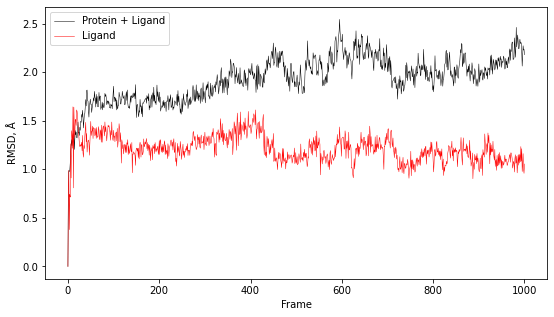

In [557]:
# RMSD vs t=0
complex_rmsd_vs_frame0 = 10*md.rmsd(
    target=trj,
    reference=trj,
    frame=0,
    atom_indices=complex_ha_index,
)
lignad_rmsd_vs_frame0 = 10*md.rmsd(
    target=trj,
    reference=trj,
    frame=0,
    atom_indices=ligand_ha_index,
)


fig, ax = plt.subplots(figsize=(9,5))
ax.plot(
    complex_rmsd_vs_frame0,
    c="k",
    linewidth=0.5,
    label="Protein + Ligand",
)
ax.plot(
    lignad_rmsd_vs_frame0,
    c="r",
    linewidth=0.5,
    label="Ligand",
)

ax.set_xlabel("Frame")
ax.set_ylabel("RMSD, Å")
ax.legend();

Cудя по нестабильному показателю RMSD комплекса, система либо не успела уравновеситься в течение 10 нс, либо пребывает в нескольких энергетически близких состояниях. Посмотрим на карту RMSD для всех пар фреймов:

In [565]:
N = trj.n_frames

complex_rmsd_matrix = np.zeros((N, N))
for frame in range(N):
    complex_rmsd_matrix[frame] = 10*md.rmsd(
        target=trj,
        reference=trj,
        frame=frame,
        atom_indices=complex_ha_index,
    )

ligand_rmsd_matrix = np.zeros((N, N))
for frame in range(N):
    ligand_rmsd_matrix[frame] = 10*md.rmsd(
        target=trj,
        reference=trj,
        frame=frame,
        atom_indices=ligand_ha_index,
    )

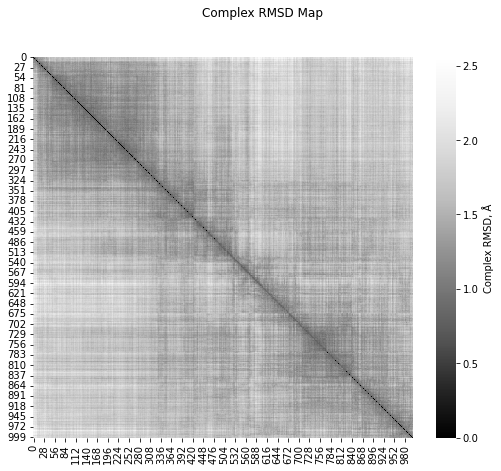

In [483]:
fig, ax = plt.subplots(figsize=(8.5,7))
sns.heatmap(
    complex_rmsd_matrix,
    ax=ax,
    cbar_kws={"label": "Complex RMSD, Å"},
    cmap="Greys_r",
)
fig.suptitle("Complex RMSD Map");

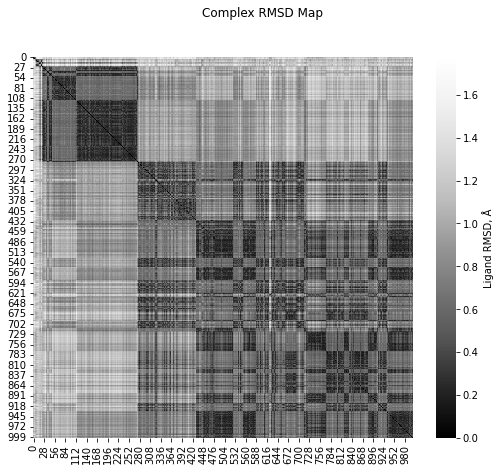

In [499]:
fig, ax = plt.subplots(figsize=(8.5,7))
sns.heatmap(
    ligand_rmsd_matrix,
    ax=ax,
    cbar_kws={"label": "Ligand RMSD, Å"},
    cmap="Greys_r",
)
fig.suptitle("Complex RMSD Map");

RMSD против фрейма, наименее удаленного от всех остальных:

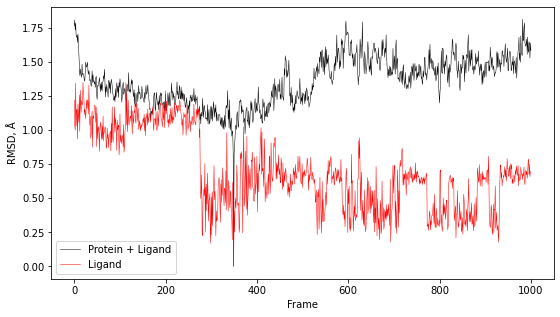

In [567]:
# RMSD vs t=0
complex_rmsd_vs_frame349 = 10*md.rmsd(
    target=trj,
    reference=trj,
    frame=349,
    atom_indices=complex_ha_index,
)
lignad_rmsd_vs_frame349 = 10*md.rmsd(
    target=trj,
    reference=trj,
    frame=349,
    atom_indices=ligand_ha_index,
)


fig, ax = plt.subplots(figsize=(9,5))
ax.plot(
    complex_rmsd_vs_frame349,
    c="k",
    linewidth=0.5,
    label="Protein + Ligand",
)
ax.plot(
    lignad_rmsd_vs_frame349,
    c="r",
    linewidth=0.5,
    label="Ligand",
)

ax.set_xlabel("Frame")
ax.set_ylabel("RMSD, Å")
ax.legend();

### Анализ водородных связей
Сначала рассмотрим связи определяемые библиотекой `mdtraj` по методу [Вернета-Нильсона](https://mdtraj.org/1.9.5/api/generated/mdtraj.wernet_nilsson.html). Выбираем интересные атомы: гетероатомы лиганда и карбоксильные кислороды D119 и D120:

In [452]:
potential_hbond_atoms = np.concatenate([
    trj.topology.select("resname CJL and (type N or type O)"),  # Ligand hetero
    trj.topology.select("(residue 119 or residue 120) and (name =~ 'OD[1-2]')"),  # D119-D120 OD*
])
print(
    *zip(potential_hbond_atoms, map(trj.topology.atom, potential_hbond_atoms)),
    sep="\n",
)

(2488, CJL157-N12)
(2495, CJL157-N01)
(2496, CJL157-N03)
(2497, CJL157-N07)
(2498, CJL157-N11)
(2499, CJL157-N15)
(2500, CJL157-O20)
(1838, ASP119-OD1)
(1839, ASP119-OD2)
(1850, ASP120-OD1)
(1851, ASP120-OD2)


Находим все водородные связи:

In [296]:
hbonds = md.wernet_nilsson(trj)

Выделяем связи с интересными атомами:

In [392]:
def linear_zeros_factory(n):
    def zeros():
        return np.zeros(n)
    return zeros

lig_hbonds = defaultdict(
    linear_zeros_factory(len(hbonds))
)

for frame_no, frame_hbonds in enumerate(hbonds):
    for atom in potential_hbond_atoms:
        bond_idx, _ = np.where(frame_hbonds == atom)
        for bond_id in bond_idx:
            hbd, _, hba = map(trj.topology.atom, frame_hbonds[bond_id])
            bond_name = f"{hbd} -> {hba}"
            lig_hbonds[bond_name][frame_no] = 1

hbdf = pd.DataFrame.from_dict(lig_hbonds)
hbdf.head()

,ASN33-ND2 -> CJL157-N03,ASP119-N -> ASP119-OD1,TRP123-NE1 -> ASP120-OD1,GLY37-N -> CJL157-O20,ASP120-N -> ASP120-OD1,ASP120-N -> ASP119-OD1,LYS38-NZ -> CJL157-O20,TYR7-OH -> CJL157-O20
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Визуализируем связи в траектории: черным цветом показаны фреймы, где связь есть

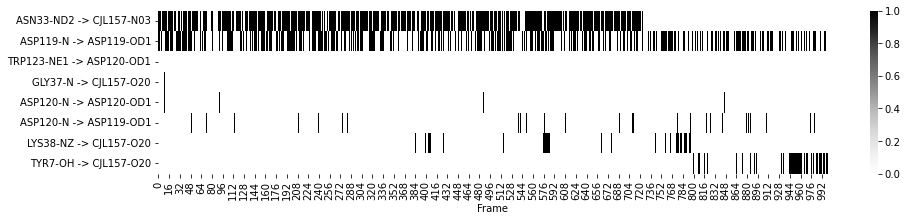

In [393]:
fig, ax = plt.subplots(figsize=(15,3))
sns.heatmap(
    hbdf.T,
    cmap="Greys",
    ax=ax,
)
ax.set_xlabel("Frame");

### Водородные связи своими руками
По какой-то причине `mdtraj` не показывает следующие водородные связи:
 - CJL-N01 -> D120-OD2
 - CJL-N11 -> D120-OD1
 - CJL-N07 -> D119-OD1/OD2
 
Соберем все возможные тройки атомов, составляющих интересные нам водородные связи:

In [472]:
potebtial_hbonds = np.asarray(
    [
        # CJL-N01 -> D120
        [
            2495,  # HBD:  CJL157-N01
            2520,  # HBH:  CJL157-H011
            1850,  # HBA:  ASP120-OD1
        ],
        [
            2495,  # CJL157-N01
            2521,  # CJL157-H012
            1850,  # ASP120-OD1
        ],
        [
            2495,  # CJL157-N01
            2520,  # CJL157-H011
            1851,  # ASP120-OD2
        ],
        [
            2495,  # CJL157-N01
            2521,  # CJL157-H012
            1851,  # ASP120-OD2
        ],
        
        # CJL-N11 -> D120
        [
            2498,  # CJL157-N11
            2523,  # CJL157-HN11
            1850,  # ASP120-OD1
        ],
        [
            2498,  # CJL157-N11
            2523,  # CJL157-HN11
            1851,  # ASP120-OD2
        ],

        # CJL-N07 -> D119
        [
            2497,  # CJL157-N07
            2522,  # CJL157-HN07
            1838,  # ASP119-OD1
        ],
        [
            2497,  # CJL157-N07
            2522,  # CJL157-HN07
            1839,  # ASP119-OD2
        ],
    ]
)
potential_hbonds_groups = {
    "CJL-N01 -> D120": slice(0, 4),
    "CJL-N11 -> D120": slice(4, 6),
    "CJL-N07 -> D119": slice(6, None),
}

И применим критерии для расстояния HBD–HBA $r_{D\cdots A} \leq 3.5\,\text{Å}$ и угла HBD–H–HBA $\angle_{D\cdots H\cdots A}\geq150^\circ$:

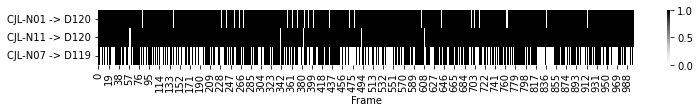

In [649]:
distance_criteria = np.where(
    md.compute_distances(
        trj,
        atom_pairs=potebtial_hbonds[:, ::2]
    ) <= 0.35,
    1, 0
)
angle_criteria = np.where(
    180*md.compute_angles(
        trj,
        potebtial_hbonds,
    )/np.pi > 150,
    1, 0
)
hbond_criteria = distance_criteria*angle_criteria

focused_hbonds = pd.DataFrame.from_dict({
    bond: np.max(hbond_criteria[:, potential_hbonds_groups[bond]], axis=1)
    for bond in potential_hbonds_groups
})

fig, ax = plt.subplots(figsize=(12, 1))
sns.heatmap(
    focused_hbonds.T,
    cmap="Greys"
)
ax.set_xlabel("Frame");

In [550]:
focused_hbonds.mean()

CJL-N01 -> D120    0.948052
CJL-N11 -> D120    0.989011
CJL-N07 -> D119    0.569431
dtype: float64

### Энергия нековалентных взаимодействий белок-лиганд
Так как на каждом шаге молекулярной динамики вычисляются энергии для _всех_ попарных взаимодействий между атомами, можно понаблюдать за отдельными термами полной энергии системы и определить вклад каждого типа взаимодействий в связывание. Для наблюдения за конкретными частями системы отмечаем в новом mdp-файле (копии `md.mdp`) энергетические группы:
```
...
energygrps              = Protein CJL
...
```
И запускаем пересчет энергии в траектории:

In [568]:
!gmx grompp \
    -f md_result/mdps/ie.mdp \
    -c md_result/mth1_complex_npt.gro \
    -t md_result/mth1_complex_npt.cpt \
    -p md_result/topol.top \
    -n md_result/index.ndx \
    -o md_result/ie.tpr

                 :-) GROMACS - gmx grompp, 2022.1-Homebrew (-:

Executable:   /usr/local/bin/../Cellar/gromacs/2022.1/bin/gmx
Data prefix:  /usr/local/bin/../Cellar/gromacs/2022.1
Working dir:  /Users/iakovlevda/Work/MC Function/md course/1. simple run/input
Command line:
  gmx grompp -f md_result/mdps/ie.mdp -c md_result/mth1_complex_npt.gro -t md_result/mth1_complex_npt.cpt -p md_result/topol.top -n md_result/index.ndx -o md_result/ie.tpr

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -114873

Generated 167797 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117519 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CJL'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule 

In [569]:
!gmx mdrun \
    -deffnm md_result/ie \
    -rerun md_result/mth1_complex_md.xtc \
    -nb cpu

                  :-) GROMACS - gmx mdrun, 2022.1-Homebrew (-:

Executable:   /usr/local/bin/../Cellar/gromacs/2022.1/bin/gmx
Data prefix:  /usr/local/bin/../Cellar/gromacs/2022.1
Working dir:  /Users/iakovlevda/Work/MC Function/md course/1. simple run/input
Command line:
  gmx mdrun -deffnm md_result/ie -rerun md_result/mth1_complex_md.xtc -nb cpu

Compiled SIMD: SSE4.1, but for this host/run AVX2_256 might be better (see
log).
Reading file md_result/ie.tpr, VERSION 2022.1-Homebrew (single precision)

Changing nstlist from 10 to 80, rlist from 1.2 to 1.317


Using 1 MPI thread
Using 8 OpenMP threads 

starting md rerun 'CJL @ MTH1 in water', reading coordinates from input trajectory 'md_result/mth1_complex_md.xtc'

Last frame       1000 time 10000.000   

NOTE: 8 % of the run time was spent in domain decomposition,
      25 % of the run time was spent in pair search,
      you might want to increase nstlist (this has no effect on accuracy)

               Core t (s)   Wall t (s)      

Записываем энергию в файл
```
gmx energy -f md_result/ie.edr -o interaction_energy.xvg
```

Выбираем составляющие `Coul-SR:Protein-CJL` и `LJ-SR:Protein-CJL`

In [577]:
def read_xvg(path: str):
    def maybe_float(f: str):
        try:
            result = float(f)
        except ValueError:
            result = f
        return result
    
    with open(path, "r") as xvg_file:
        xvg_content = xvg_file.readlines()
    entries = []
    for line in xvg_content:
        if not (line.startswith("@") or line.startswith("#")):
            entry = dict(enumerate(map(maybe_float, line.strip().split())))
            entries.append(entry)
    return pd.DataFrame.from_records(entries)

In [648]:
nc_energies = read_xvg("interaction_energy.xvg")
nc_energies.columns = ["time", "coulomb", "lj"]
nc_energies["sum"] = nc_energies["coulomb"] + nc_energies["lj"]
nc_energies.describe().loc[["mean", "std"], ["coulomb", "lj", "sum"]]

,coulomb,lj,sum
mean,-578.762648,-51.261772,-630.024420
std,34.151597,21.473289,35.686572


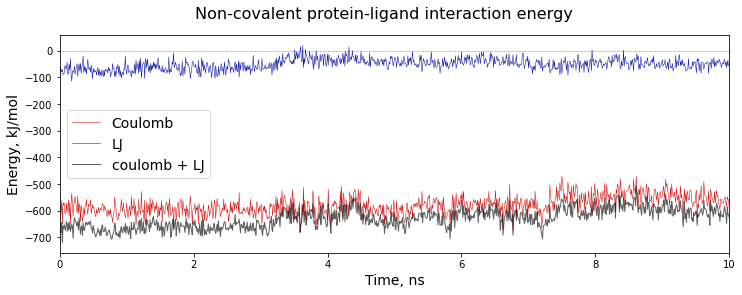

In [639]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    nc_energies["time"]/1000,
    nc_energies["coulomb"],
    c="#d00000",
    label="Coulomb",
    linewidth=0.5,
)
ax.plot(
    nc_energies["time"]/1000,
    nc_energies["lj"],
    c="#0008a0",
    label="LJ",
    linewidth=0.5,
)
ax.plot(
    nc_energies["time"]/1000,
    nc_energies["coulomb"] + nc_energies["lj"],
    c="#000000a0",
    label="coulomb + LJ",
    linewidth=1,
)
ax.plot(
    nc_energies["time"]/1000,
    nc_energies["time"]*0,
    linestyle=":",
    linewidth=0.5,
    c="#000000"
)
ax.legend(fontsize=14)
ax.set_xlabel("Time, ns", fontsize=14)
ax.set_xlim(0, 10)
ax.set_ylabel("Energy, kJ/mol", fontsize=14)
fig.suptitle("Non-covalent protein-ligand interaction energy", fontsize=16);

Можно заметить, что вклад кулоновских взаимодействий в связывание значительно выше, чем вдВ, скорее всего из-за образования ионной пары в активном центре белка.